In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from patsy import dmatrices
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

## Read data

In [3]:
data = pd.read_csv('train.csv', sep=',', header = 0)

In [5]:
data.shape

(891, 12)

In [6]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
data = data.drop(['Ticket', 'Cabin'], axis = 1)

In [9]:
data = data.dropna()

In [10]:
data.shape

(712, 10)

## EDA

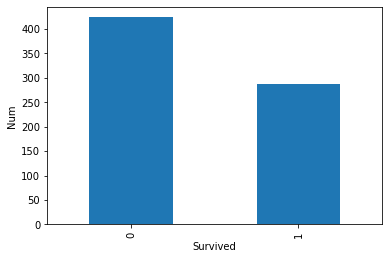

In [13]:
# survival rate
data['Survived'].value_counts().plot(kind = 'bar')
plt.xlabel('Survived')
plt.ylabel('Num')
plt.show()

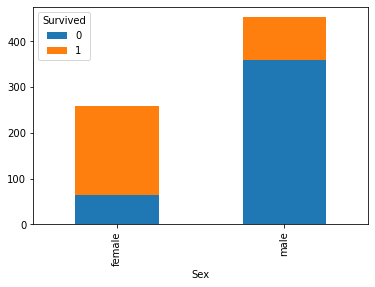

In [16]:
# gender
pd.crosstab(data['Sex'], data['Survived']).plot(kind='bar', stacked=True)
plt.show()

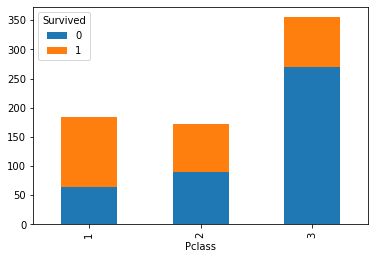

In [19]:
# pclass
pd.crosstab(data['Pclass'], data['Survived']).plot(kind='bar', stacked=True)
plt.show()

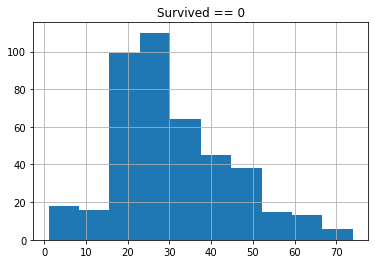

In [20]:
# age
data[data['Survived'] == 0]['Age'].hist()
plt.title('Survived == 0')
plt.show()

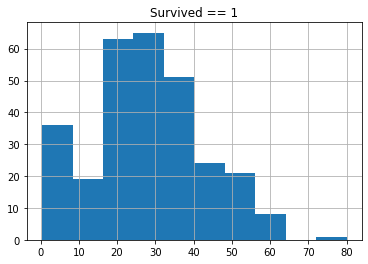

In [21]:
data[data['Survived'] == 1]['Age'].hist()
plt.title('Survived == 1')
plt.show()

## Train Model

In [22]:
y, X = dmatrices('Survived~C(Pclass) + C(Sex) + Age + C(Embarked)', data = data, return_type='dataframe')
y = np.ravel(y)

In [23]:
X.shape, y.shape

((712, 7), (712,))

In [25]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [27]:
# in sample accuracy
model.score(X, y)

0.7935393258426966

## Test

In [28]:
test_data = pd.read_csv('test.csv', sep=',', header=0)
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [30]:
test_data['Survived'] = 1
test_data['Age'] = test_data['Age'].fillna(np.mean(data['Age']))

In [33]:
y_test, X_test = dmatrices('Survived~C(Pclass) + C(Sex) + Age + C(Embarked)', data = test_data, return_type='dataframe')
y_test = np.ravel(y_test)

In [34]:
X_test.shape

(418, 7)

In [35]:
pred = model.predict(X_test)
solution = pd.DataFrame(list(zip(test_data['PassengerId'], pred)), columns=['PassengerID', 'Survived'])

In [37]:
solution

,PassengerID,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0
...,...,...
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0


## Precision Recall

In [38]:
precs = []
recalls = []
scores = model.predict_proba(X)
min_score = min([s[1] for s in scores])
max_score = max([s[1] for s in scores])
for threshold in np.arange(0, 1, 0.01):
    # prediction score above threshold is considered as positive
    if threshold < min_score or threshold > max_score:
        continue
    preds = [1 if s[1] >= threshold else 0 for s in scores]
    TP = sum([1 for gt, pred in zip(y, preds) if gt == 1 and pred == 1])
    FP = sum([1 for gt, pred in zip(y, preds) if gt == 0 and pred == 1])
    FN = sum([1 for gt, pred in zip(y, preds) if gt == 1 and pred == 0])
    if TP + FP == 0:
        precs.append(0.0)
    else:
        precs.append(TP / (TP + FP + 0.0))
    if TP + FN == 0:
        recalls.append(0.0)
    else:
        recalls.append(TP / (TP + FN + 0.0))

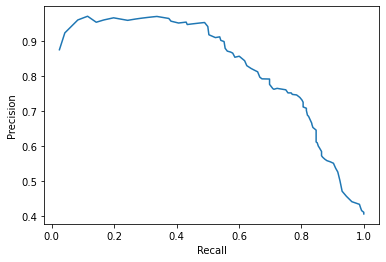

In [39]:
plt.plot(recalls, precs, ls='-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()